In [91]:
import tsnet
import matplotlib.pyplot as plt
# open an example network and create a transient model
inp_file = 'Tnet3.inp'
inp_file = 'single_pipe_leak.inp'

emitter_coeffs = [0, 0.001]


tms = [tsnet.network.TransientModel(inp_file) for _ in emitter_coeffs]


# Set wavespeed

for i, tm in enumerate(tms):
    tm.set_wavespeed(1200)
    tf = 600 # simulation period [s]
    tm.set_time(tf)

    # Add leak
    tm.add_leak('JUNCTION-0', emitter_coeffs[i])

    # Initialize steady state simulation
    t0 = 0. # initialize the simulation at 0s
    engine = 'DD' # or Epanet
    tm = tsnet.simulation.Initializer(tm, t0, engine)

    # Transient simulation
    result_obj = f'TSNet_{emitter_coeffs[i]}' # name of the object for saving simulation results
    tm = tsnet.simulation.MOCSimulator(tm,result_obj)

Simulation time step 0.50000 s
Total Time Step in this simulation 1200
Estimated simulation time 0:00:00.331200
Transient simulation completed 10 %...
Transient simulation completed 20 %...
Transient simulation completed 30 %...
Transient simulation completed 40 %...
Transient simulation completed 50 %...
Transient simulation completed 60 %...
Transient simulation completed 70 %...
Transient simulation completed 80 %...
Transient simulation completed 90 %...
Simulation time step 0.50000 s
Total Time Step in this simulation 1200
Initial condition discrepancy of pressure (-0.5481 m) on the JUNCTION-0 node
Initial condition discrepancy of pressure (-0.5481 m) on the JUNCTION-0 node
Estimated simulation time 0:00:00.158400
Transient simulation completed 10 %...
Transient simulation completed 20 %...
Transient simulation completed 30 %...
Transient simulation completed 40 %...
Transient simulation completed 50 %...
Transient simulation completed 60 %...
Transient simulation completed 70 %..

In [92]:
import wntr
import matplotlib.pyplot as plt

# Load the base model
inp_file = 'single_pipe_leak.inp'
wn_leak = wntr.network.WaterNetworkModel(inp_file)
wn_no_leak = wntr.network.WaterNetworkModel(inp_file)

# Remove emitter from no-leak model
junction_name = 'JUNCTION-0'
wn_no_leak.get_node(junction_name).emitter_coefficient = 0.0

# Set leak emitter coefficient in leak model
wn_leak.get_node(junction_name).emitter_coefficient = 0.1  # [m^3/s]/(m H2O)^0.5

# Run steady-state simulations
sim = wntr.sim.EpanetSimulator

results_no_leak = sim(wn_no_leak).run_sim()
results_leak = sim(wn_leak).run_sim()

# Extract results (head, pressure, flow, demand)
head_no_leak = results_no_leak.node['head']
head_leak = results_leak.node['head']

pressure_no_leak = results_no_leak.node['pressure']
pressure_leak = results_leak.node['pressure']

flowrate_no_leak = results_no_leak.link['flowrate']
flowrate_leak = results_leak.link['flowrate']


In [93]:
print('FLOWRATE LEAK:')
print(flowrate_leak)

FLOWRATE LEAK:
name    PIPE-0  PIPE-1
0     0.746614    0.05


In [94]:
print('PRESSURE NO LEAK:')
print(pressure_no_leak)


PRESSURE NO LEAK:
name  JUNCTION-0  JUNCTION-1     RESERVOIR
0      49.990143   49.970432 -7.812500e-07


In [95]:
print('PRESSURE LEAK:')
print(pressure_leak)

PRESSURE LEAK:
name  JUNCTION-0  JUNCTION-1     RESERVOIR
0      48.527058   48.507347 -7.812500e-07


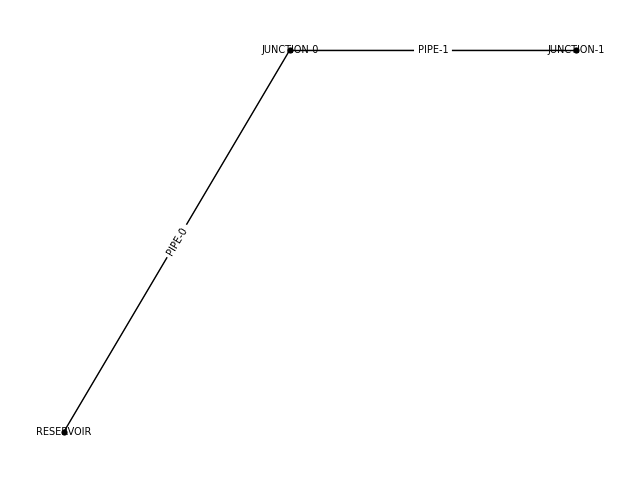

In [96]:
from wntr.graphics import plot_network
import matplotlib.pyplot as plt

# Plot just the structure of the network
fig, ax = plt.subplots(figsize=(8, 6))
plot_network(tm, node_labels=True, link_labels=True, ax=ax)
plt.show()

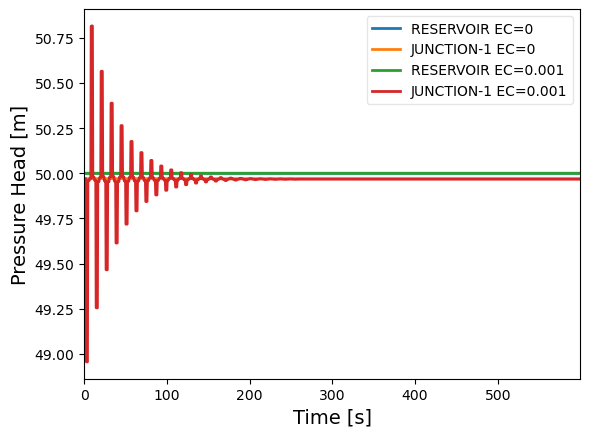

In [97]:
names = ['RESERVOIR', 'JUNCTION-1']

fig, ax = plt.subplots(1, 1)

def _plot_node_head(tm, idx, name, ax=None):
        """Detect pressure change in simulation results

        Parameters
        ----------
        name : str or list
            The name of node
        ax : a matplotlib.axes.Axes instance, optional (default = None).
        """
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            print('matplotlib is not available.')
        else:
            if ax is None:
                fig, ax = plt.subplots(1, 1, figsize=(8,4),dpi=100, facecolor='w', edgecolor='k')
        if not type(name) is list:
            name = [name]
        nodes = [tm.get_node(i) for i in name]
        time = tm.simulation_timestamps

        for i,node in enumerate(nodes):
            ax.plot(time, node._head, lw=2, label=f'{name[i]} EC={emitter_coeffs[idx]}')
        plt.xlim([tm.simulation_timestamps[0],tm.simulation_timestamps[-1]])
        # plt.title('Pressure Head at Node(s) ')
        plt.xlabel("Time [s]", fontsize=14)
        plt.ylabel("Pressure Head [m]", fontsize=14)
        plt.legend(loc='best', framealpha=.5, numpoints=1)
        #plt.grid(False)

for idx, tm in enumerate(tms):
    _plot_node_head(tm, idx, names, ax=ax)


In [98]:

for i, tm in enumerate(tms):

    node = tm.get_node('JUNCTION-1')
    print(node._head[-1])

49.97043182557881
49.96744902627174


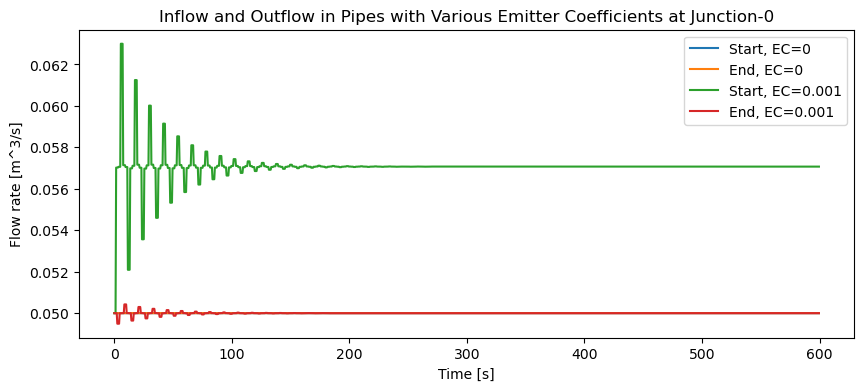

In [99]:
plt.figure(figsize=(10, 4))

for i, tm in enumerate(tms):
    
    

    plt.plot(tm.simulation_timestamps, tm.get_link('PIPE-0').start_node_flowrate, label=f'Start, EC={emitter_coeffs[i]}')
    plt.plot(tm.simulation_timestamps, tm.get_link('PIPE-1').end_node_flowrate, label=f'End, EC={emitter_coeffs[i]}')

    plt.title(f'Inflow and Outflow in Pipes with Various Emitter Coefficients at Junction-0')
    plt.xlabel("Time [s]")
    plt.ylabel("Flow rate [m^3/s]")
    plt.legend(loc='best')
    
    
plt.show()